## Importing Libraries

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = [14, 6]
sns.set(style="whitegrid")

In [3]:
pwd

'C:\\Users\\user\\Desktop\\DSTI\\Machine Learning with Python Labs\\GroupProject\\notebooks'

In [4]:
# pd.options.display.float_format = '{:,.0f}'.format

## Importing data

In [5]:
orders = pd.read_csv("orders.csv")
order_products_train = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv")
departments = pd.read_csv("departments.csv")
aisles = pd.read_csv("aisles.csv")

## Input data

In [6]:
max_len = 2
list_department_id = [4, 16, 5, 8]
list_aisle_id = []


## Exploratory Data Analysis

In [7]:
df_check = order_products_prior.merge(order_products_train, on = "order_id", how = "inner")

In [8]:
# check if order_products_prior has the same data with order_products_train or not

In [9]:
df_check.head()

,order_id,product_id_x,add_to_cart_order_x,reordered_x,product_id_y,add_to_cart_order_y,reordered_y


In [10]:
# df_check returns nothing, so there is no any duplicate "order_id" data in order_products_prior and order_products_train

In [11]:
order_products = pd.concat([order_products_train, order_products_prior])

In [12]:
data = order_products.merge(products, on = "product_id", how = "left")

In [13]:
data = data.merge(aisles, on = "aisle_id", how = "left")

In [14]:
data = data.merge(departments, on = "department_id", how = "left")

In [15]:
data = data.merge(orders, on = "order_id", how = "left")

In [16]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [17]:
data.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01
std,9.874008e+05,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


## ADD SYNTHETIC PRICES

In [18]:
# Merge products with aisles and departments
products = products.merge(aisles, on="aisle_id", how="left")
products = products.merge(departments, on="department_id", how="left")


In [19]:
print(products.columns)


Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'aisle',
       'department'],
      dtype='object')


In [20]:


# Reproducibility
rng = np.random.default_rng(42)

# ---- 1) Make sure you have department info joined into products ----
# Expected columns in products after merging:
# products: product_id, product_name, aisle_id, department_id, aisle, department

# If you don't have aisle/department merged yet, uncomment and adapt this:
# products = products.merge(aisles, on="aisle_id", how="left").merge(departments, on="department_id", how="left")

# ---- 2) Department-based price "typical" behavior ----
# Values are (median_price, dispersion) for a lognormal distribution.
# lognormal is good because prices are positive and skewed (many cheap items, few expensive).
dept_pricing = {
    "produce": (2.5, 0.45),
    "dairy eggs": (3.5, 0.35),
    "beverages": (4.0, 0.55),
    "snacks": (3.0, 0.50),
    "frozen": (4.5, 0.35),
    "pantry": (3.0, 0.50),
    "bakery": (3.5, 0.35),
    "meat seafood": (8.0, 0.45),
    "deli": (6.0, 0.35),
    "breakfast": (4.0, 0.40),
    "canned goods": (2.5, 0.40),
    "dry goods pasta": (2.8, 0.40),
    "international": (3.5, 0.45),
    "household": (6.0, 0.60),
    "personal care": (6.5, 0.60),
    "babies": (10.0, 0.60),
    "pets": (9.0, 0.55),
    "alcohol": (12.0, 0.55),
    "other": (4.0, 0.60),
}

# Fallback if department is missing or unknown
default_median, default_sigma = (4.0, 0.60)

# Hard caps to avoid insane outliers (in USD-like units)
MIN_PRICE = 0.49
MAX_PRICE = 49.99

def lognormal_from_median(median: float, sigma: float, size: int = 1):
    """
    For a lognormal distribution, median = exp(mu).
    So mu = log(median).
    """
    mu = np.log(median)
    return rng.lognormal(mean=mu, sigma=sigma, size=size)

def assign_synthetic_price(dept: str) -> float:
    dept_key = str(dept).strip().lower() if pd.notna(dept) else None
    median, sigma = dept_pricing.get(dept_key, (default_median, default_sigma))
    price = float(lognormal_from_median(median, sigma, 1)[0])

    # Clamp and round to 2 decimals
    price = max(MIN_PRICE, min(MAX_PRICE, price))
    return round(price, 2)

# ---- 3) Apply to all products ----
if "department" not in products.columns:
    raise ValueError("Column 'department' not found in products. Merge departments into products first.")

products["synthetic_price"] = products["department"].apply(assign_synthetic_price)

# ---- 4) Optional: add small variations by aisle (makes it look more realistic) ----
# Example: slight aisle multiplier if aisle info exists
if "aisle" in products.columns:
    # Random multiplier per aisle between -8% and +8%
    aisle_factors = (products["aisle"].dropna().unique())
    aisle_multiplier = {a: float(rng.uniform(0.92, 1.08)) for a in aisle_factors}

    products["synthetic_price"] = (
        products.apply(
            lambda r: round(
                max(MIN_PRICE, min(MAX_PRICE, r["synthetic_price"] * aisle_multiplier.get(r["aisle"], 1.0))),
                2
            ),
            axis=1
        )
    )

# ---- 5) Quick sanity checks ----
print(products["synthetic_price"].describe())

# View a few examples
products[["product_id", "product_name", "department", "aisle", "synthetic_price"]].sample(10, random_state=1)


count    49688.000000
mean         5.211658
std          4.236293
min          0.490000
25%          2.720000
50%          4.000000
75%          6.130000
max         49.990000
Name: synthetic_price, dtype: float64


,product_id,product_name,department,aisle,synthetic_price
22401,22402,Minute Multi-Grain Medley Microwaveable Rice B...,dry goods pasta,instant foods,2.86
14796,14797,"Liquid Laundry Detergent, Daybreak Fresh Scent",household,laundry,1.54
38552,38553,"Bean, Rice and Cheddar Burrito",frozen,frozen meals,5.16
11805,11806,Paleo Blueberry Muffin,missing,missing,3.90
9336,9337,Purity Farms Ghee Clarified Butter,dairy eggs,butter,3.64
19927,19928,Swirl Women's Razor Blade Refills,personal care,shave needs,8.45
1169,1170,Tricolor Penne,dry goods pasta,dry pasta,2.37
12561,12562,Beefaroni,canned goods,canned meals beans,3.57
2852,2853,Organic Blueberry Hemp Superfood Snack,snacks,nuts seeds dried fruit,5.64
15668,15669,The Organic Candy Bar Mocha Bar,snacks,candy chocolate,3.58


## Check Total Order By Each User

In [21]:
df_last_order = (
    data.groupby("user_id")["order_number"]
    .max()
    .reset_index(name="total_order")
)

In [22]:
df_last_order.head()

,user_id,total_order
0,1,11
1,2,15
2,3,12
3,4,5
4,5,5


In [23]:
df_last_order.describe()

,user_id,total_order
count,206209.000000,206209.000000
mean,103105.000000,16.226658
std,59527.555167,16.662238
min,1.000000,3.000000
25%,51553.000000,6.000000
50%,103105.000000,10.000000
75%,154657.000000,20.000000
max,206209.000000,100.000000


In [25]:
# [Observation]: 
# 1. The majority of user made from 10-20 orders
# 2. The total order by user is imbalanced

## Check The Amount Of Product That Is Order By User

In [26]:
# Get the number of ordered products by each user

In [27]:
data_number_of_ordered_products_by_user = (
    data.groupby("user_id")["product_id"]
    .size()
    .reset_index(name="Total_Products")
)

In [28]:
data_number_of_ordered_products_by_user.head()

,user_id,Total_Products
0,1,70
1,2,226
2,3,88
3,4,18
4,5,46


In [29]:
# Get the number of unique products that is ordered by users

In [30]:
data_number_of_unique_ordered_products_by_user = (
    data.groupby("user_id")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [31]:
data_number_of_unique_ordered_products_by_user.head()

,user_id,Total_Products
0,1,19
1,2,121
2,3,33
3,4,17
4,5,28


In [32]:
# [Observation]: 
# 1. The number of ordered products is much more higher than the number of unique ordered products by each user.

# [Insights]
#1. Users tend to buy a certain kinds of product repetively.

# [Possible Solutions]



## Tasks To Do 

In [33]:
# Use unsupervised learning algorithm to discover the possible user group (Clustering)

# Maybe there are certain type of user group:
# 1. who often buys the products from a specific department/aisle
# 2. who often goes shopping on a specific day 
# 3. who often goes shopping on a specific time

# For option 2 + 3: try to discover as well which products that users ordered, and these products belong to which type of Department/Aisle

## Check Total Order By Week Days

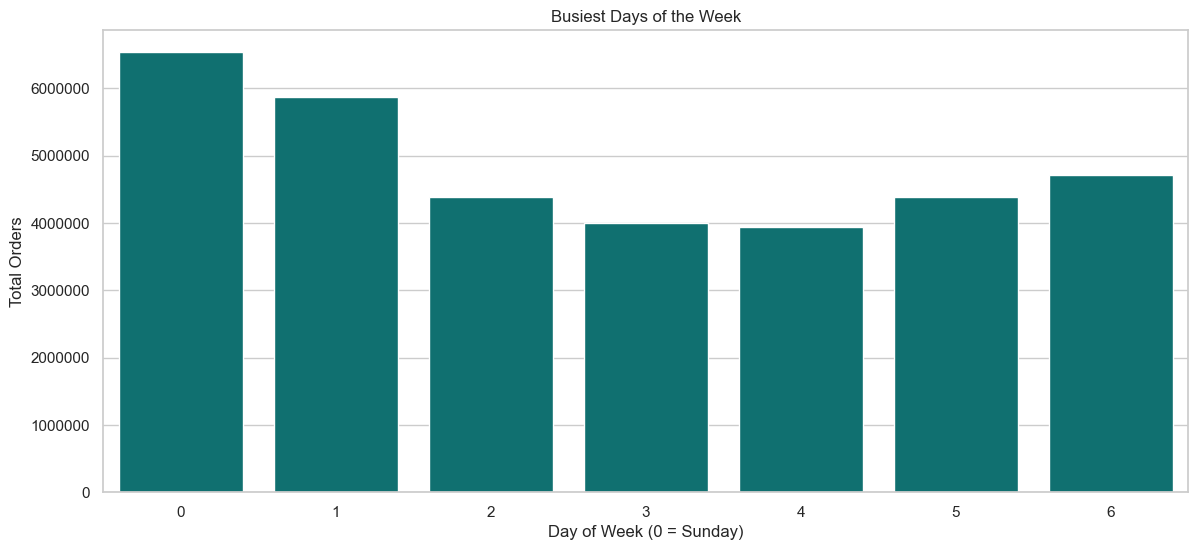

In [34]:
sns.countplot(x='order_dow', data = data, color='teal')
plt.title('Busiest Days of the Week')
plt.xlabel('Day of Week (0 = Sunday)')
plt.ylabel('Total Orders')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [35]:
# [Observation]: 
# 1. Users tend to order the most on the weekend (Saturday, Sunday) + Monday
# 2. Users order less on Wednesday and Thursday

# [Insights]
# 1. During the weekend, users do not need to work, so they have more free time to go shopping online 
# 2. Users often have party or do more activities on the week-end, so they need to order more than normally
# 3. Because there are a lot of activities to do on the week-end, so the products are out-of-stock quickly,
# so they need to restock again on Monday.
# 4. On Wednesday and Thursday, users have to work, so they do not have time to go shopping online
# 5. There are less activities on Wednesday and Thursday normally

# [Possible Solutions]
# 1. Implement sales promotion programs (buy 1 get 1 / discount 20%) to clear inventory on Wednesday and Thursday.
# 2. Creating products combo to push the order value or freeshipping for a certain 
# value of order (ex: free-ship for order greater than 400 euros) on the week-end.
# 3. 

## Check Order Distribution By Hours Of Day

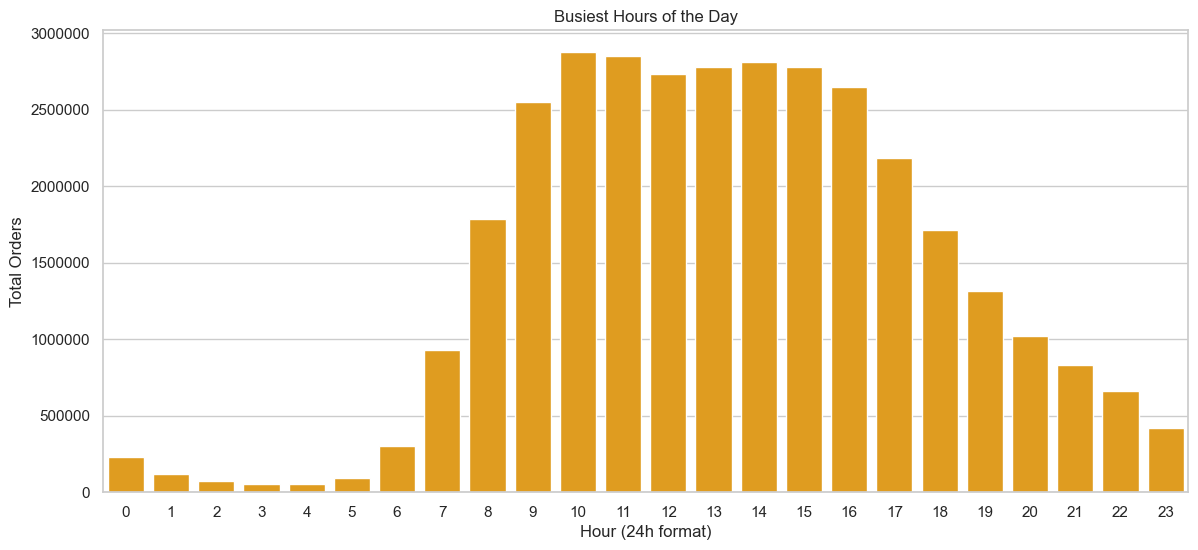

In [36]:
# 2. Orders by Hour of Day
sns.countplot(x='order_hour_of_day', data=data, color='orange')
plt.title('Busiest Hours of the Day')
plt.xlabel('Hour (24h format)')
plt.ylabel('Total Orders')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [37]:
# [Observation]: 
# 1. Users tend to order the most from 8h a.m to 18h p.m

# [Insights]
# 1. From 8h a.m to 18h p.m is the time for daily activities, so users make order the most on this time.
# 2. Most of supermarkets open this time, so users have more choice to choose and order products.
# 3. From 8h a.m to 18h p.m, maybe there are more shippers, so the shipping fee is cheaper.
# 4. From 18h p.m to 23h p.m, maybe some supermarkets close, so users have less choices to order.
# 5. From 18h p.m to 23h p.m, maybe there are less shippers, so the shipping fee is more expensive. 
# 6. From 0 a.m to 6 p.m is the time for sleeping, if users make orders this time, it could be someone
# who works on a different timezone, who has night party, who have some unpredictable urgencies.

# [Possible Solutions]
# 1. Having free-shipping discount for high value orders from 18h p.m to 23h p.m to push sale up.
# 2. 

## Check Order And Product Distribution By Asile

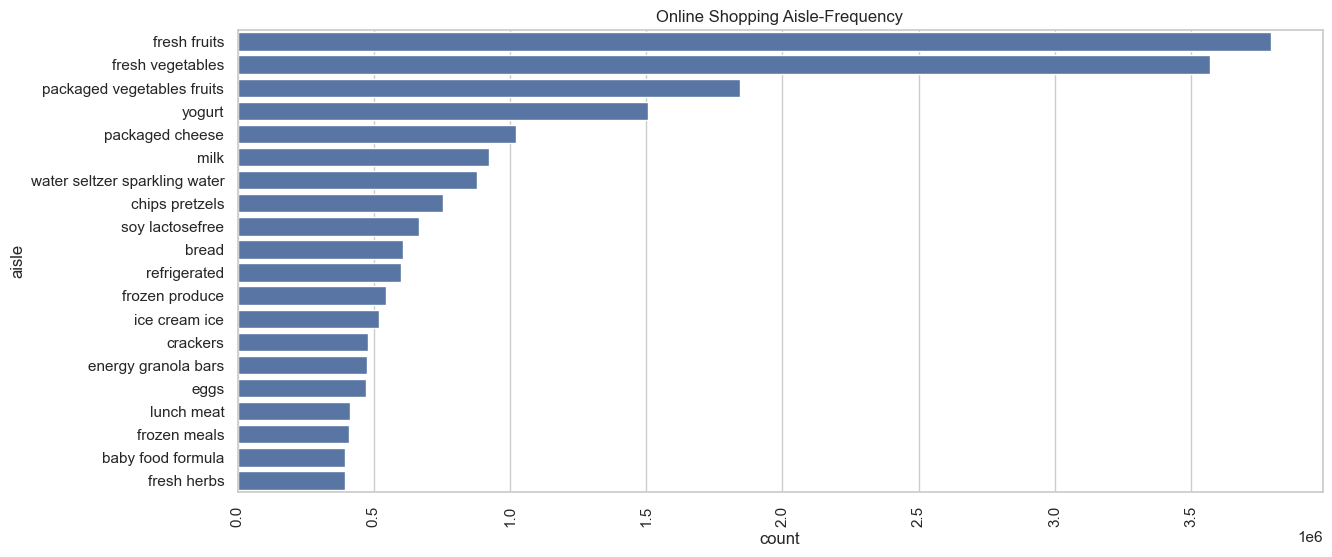

In [38]:
sns.countplot(data.aisle, order=data.aisle.value_counts().index[:20])
plt.title('Online Shopping Aisle-Frequency')
plt.xticks(rotation=90)
plt.show()

In [39]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain aisles that have more orders than the others.

# [Insights]
# 1. Maybe there are some certain aisles that include more products than the others
# 2. People tend to buy repetively a certain kind of products

# [Possible Solutions]


In [40]:
data_by_aisle = (
    data.groupby("aisle")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [41]:
data_by_aisle.head()

,aisle,Total_Products
0,air fresheners candles,355
1,asian foods,605
2,baby accessories,44
3,baby bath body care,132
4,baby food formula,718


In [42]:
df_top_20_aisle = data_by_aisle.sort_values("Total_Products", ascending=False).head(20)

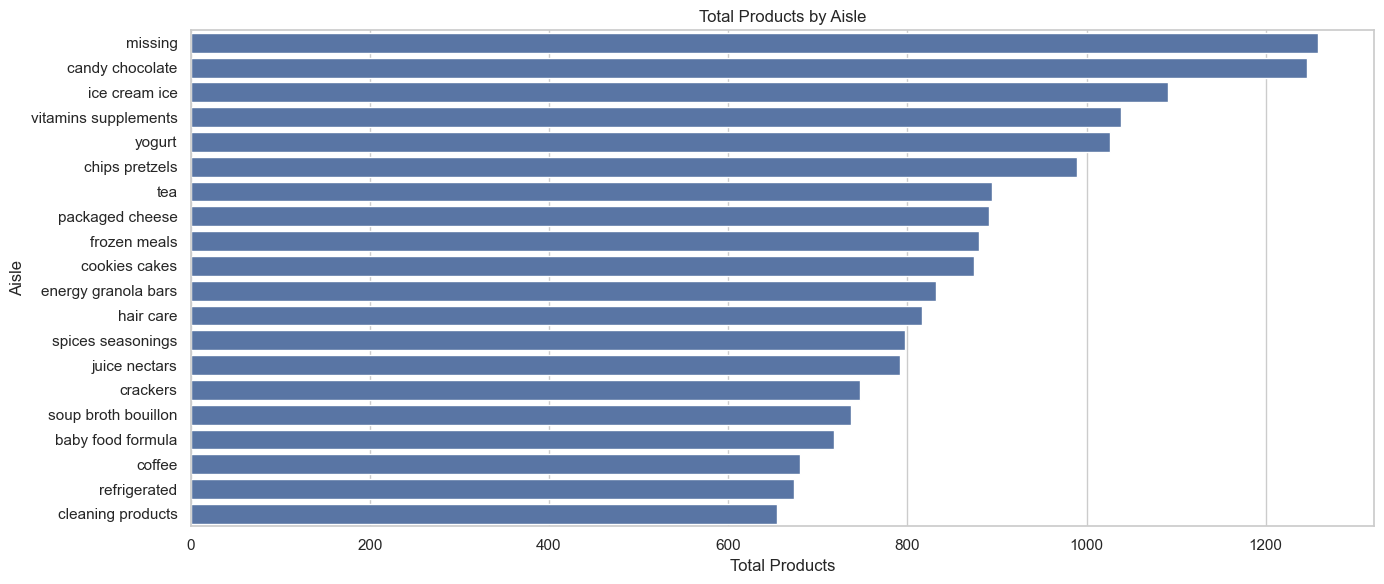

In [43]:
sns.barplot(
    data=df_top_20_aisle,
    x="Total_Products",
    y="aisle"
)
plt.title("Total Products by Aisle")
plt.xlabel("Total Products")
plt.ylabel("Aisle")
plt.tight_layout()
plt.show()

In [44]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain aisles that have more products than the others.

# [Insights]
# 1. 

# [Possible Solutions]


## Check Order And Product Distribution By Department

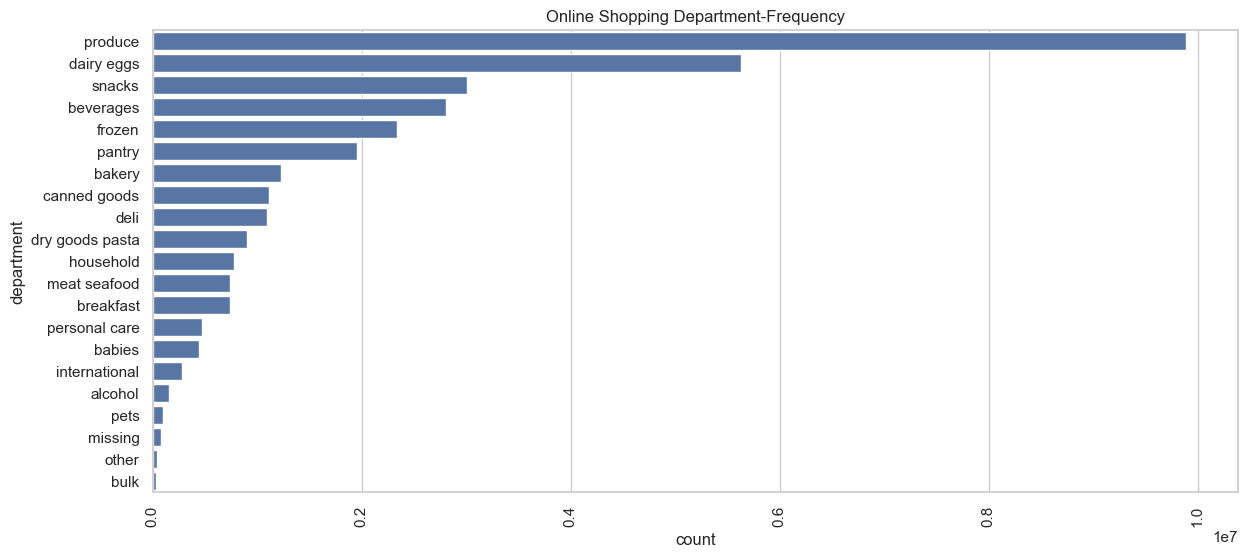

In [45]:
sns.countplot(data.department, order=data.department.value_counts().index)
plt.title('Online Shopping Department-Frequency')
plt.xticks(rotation=90)
plt.show()

In [46]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain departments that have more orders than the others.

# [Insights]
# 1. Maybe there are some certain departments that include more products than the others
# 2. People tend to buy repetively a certain kind of products

# [Possible Solutions]


In [47]:
data_by_department = (
    data.groupby("department")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [48]:
data_by_department = data_by_department.sort_values("Total_Products", ascending=False)

In [49]:
data_by_department.head(10)

,department,Total_Products
17,personal care,6563
20,snacks,6264
16,pantry,5370
3,beverages,4364
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


In [50]:
data_by_department.describe()

,Total_Products
count,21.000000
mean,2365.952381
std,1914.269508
min,38.000000
25%,1081.000000
50%,1516.000000
75%,3449.000000
max,6563.000000


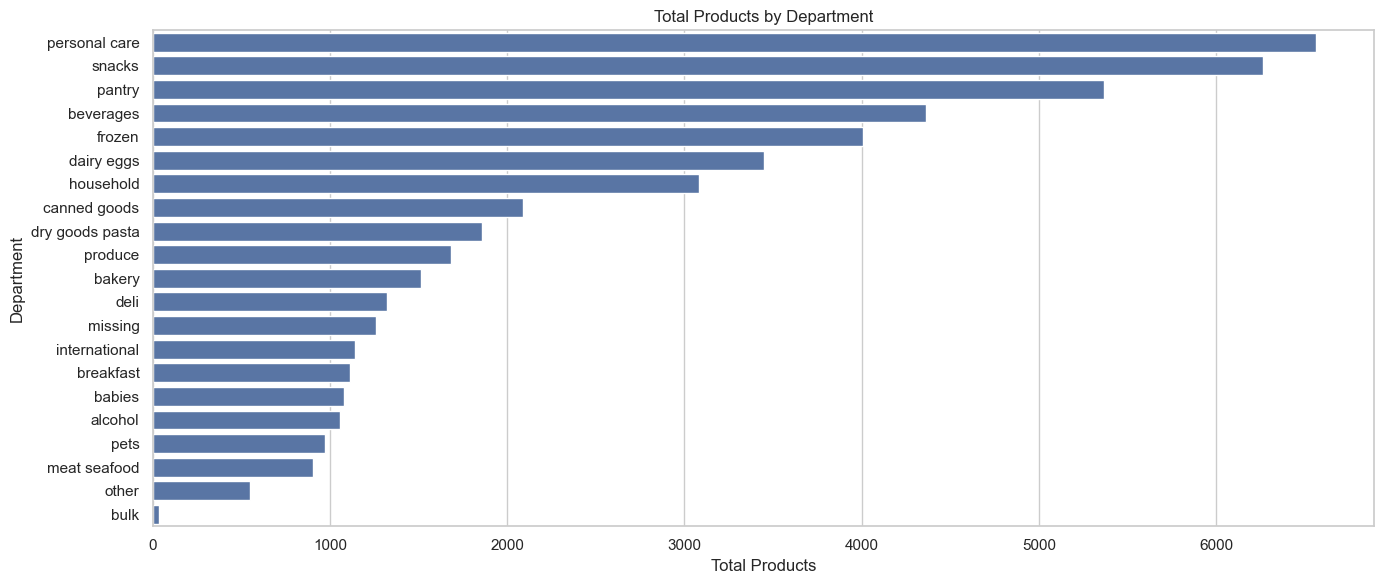

In [51]:
sns.barplot(
    data=data_by_department,
    x="Total_Products",
    y="department"
)
plt.title("Total Products by Department")
plt.xlabel("Total Products")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

In [52]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain departments that have more products than the others.

# [Insights]
# 1. 

# [Possible Solutions]
# 1. If we want to push the sale up for the less productive department/aisle, we need to have more products for that.

## Check The Relationship Between Aisle And Department

In [53]:
data_aisle_by_department = (
    data.groupby("department")["aisle_id"]
    .nunique()
    .reset_index(name="Total_Aisles")
)

In [54]:
data_aisle_by_department.head()

,department,Total_Aisles
0,alcohol,5
1,babies,4
2,bakery,5
3,beverages,8
4,breakfast,4


In [55]:
data_aisle_by_department.describe()

,Total_Aisles
count,21.000000
mean,6.380952
std,4.128876
min,1.000000
25%,4.000000
50%,5.000000
75%,10.000000
max,17.000000


In [56]:
data_aisle_by_department = data_aisle_by_department.sort_values("Total_Aisles", ascending=False)

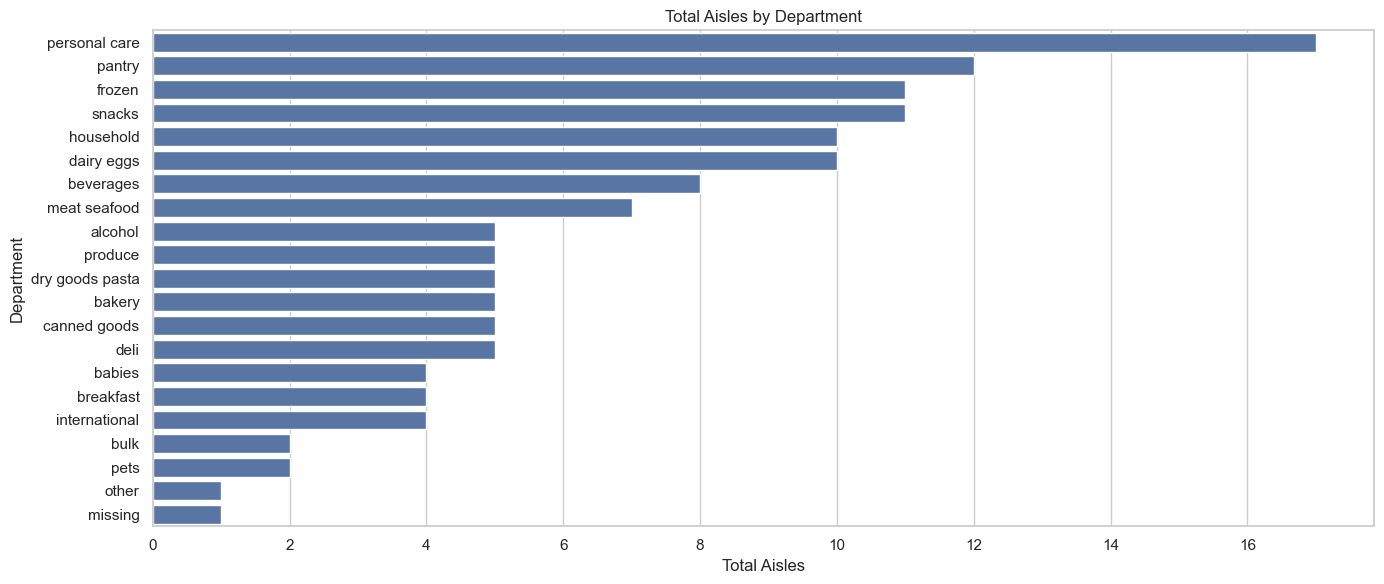

In [57]:
sns.barplot(
    data=data_aisle_by_department,
    x="Total_Aisles",
    y="department"
)
plt.title("Total Aisles by Department")
plt.xlabel("Total Aisles")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

In [58]:
# [Observation]: 
# 1. Personal Care, Household, Meat Seafood have a higher number of Aisle than the average, but they are
# ordered by users less than the average.

# [Insights]
# 1. 

# [Possible Solutions]


## IMPLEMENTING SOLUTION

## Check if user wants to discover products relationship by aisle or by department

In [59]:
data_unique = data.drop_duplicates(subset=["user_id","product_id"])
data = data_unique

In [60]:
selected_column = ""
if len(list_department_id) > 0:
    data = data[data['department_id'].isin(list_department_id)]
    selected_column = "department"
elif len(list_aisle_id) > 0:
    data = data[data['aisle_id'].isin(list_aisle_id)]
    selected_column = "aisle"
else:
    data = data

In [61]:
data.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
5,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
6,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
7,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs,112108,train,4,4,10,9.0
8,36,39612,1,0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs,79431,train,23,6,18,30.0
10,36,49235,3,0,Organic Half & Half,53,16,cream,dairy eggs,79431,train,23,6,18,30.0
11,36,43086,4,1,Super Greens Salad,123,4,packaged vegetables fruits,produce,79431,train,23,6,18,30.0


In [62]:
# only need order_id and product_name for discovering

In [63]:
data_explore = data[['order_id', 'product_id','product_name']]

In [64]:
df_products_number = (
    data_explore.groupby("product_name")["product_name"]
    .size()
    .reset_index(name="total_order")
)

In [65]:
df_products_number.describe()

,total_order
count,7159.000000
mean,757.376030
std,3158.647667
min,1.000000
25%,16.000000
50%,60.000000
75%,298.000000
max,76125.000000


In [66]:
df_products_number.isna().sum()

product_name    0
total_order     0
dtype: int64

In [67]:
total_order = data_explore["order_id"].nunique()

In [68]:
# count how many different orders in the dataset

In [69]:
print(total_order)

1855819


In [70]:
data_explore.head(10)

,order_id,product_id,product_name
0,1,49302,Bulgarian Yogurt
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,10246,Organic Celery Hearts
3,1,49683,Cucumber Kirby
5,1,13176,Bag of Organic Bananas
6,1,47209,Organic Hass Avocado
7,1,22035,Organic Whole String Cheese
8,36,39612,Grated Pecorino Romano Cheese
10,36,49235,Organic Half & Half
11,36,43086,Super Greens Salad


In [71]:
# only choosing the product/group of products that appear at least 0.3% in the total orders

In [72]:
support_point = 0.003

In [73]:
# ============================
# SAFE BASKET BUILD (SAMPLE)
# ============================

# 1) Tomamos una muestra de órdenes (para que no explote la RAM)
SAMPLE_ORDERS = 50_000   # probá 20_000 si tu compu es más justa

sample_order_ids = (
    data_explore["order_id"]
    .drop_duplicates()
    .sample(SAMPLE_ORDERS, random_state=42)
)

data_fp = data_explore[data_explore["order_id"].isin(sample_order_ids)].copy()

# 2) Evitar duplicados dentro del mismo pedido (importante)
data_fp = data_fp.drop_duplicates(["order_id", "product_id"])

# 3) Construir baskets (ojo: SIN .tolist() todavía)
basket = data_fp.groupby("order_id")["product_id"].apply(list)

print("Baskets:", basket.shape[0], "| Rows in data_fp:", data_fp.shape[0])


# --- compute min_count for THIS sample ---
n_orders = data_fp["order_id"].nunique()
min_count = int(np.ceil(support_point * n_orders))

# --- count in how many orders each product appears ---
prod_order_counts = data_fp.groupby("product_id")["order_id"].nunique()

# --- keep only products that can possibly meet min_support ---
keep_products = prod_order_counts[prod_order_counts >= min_count].index

data_fp = data_fp[data_fp["product_id"].isin(keep_products)].copy()

print("Orders (sample):", n_orders)
print("Min count:", min_count)
print("Products before:", prod_order_counts.shape[0], "after:", len(keep_products))
print("Rows after product filter:", data_fp.shape[0])

basket = data_fp.groupby("order_id")["product_id"].apply(list)
print("Baskets:", basket.shape[0], "| Rows in data_fp:", data_fp.shape[0])



Baskets: 50000 | Rows in data_fp: 145761
Orders (sample): 50000
Min count: 150
Products before: 4806 after: 204
Rows after product filter: 80832
Baskets: 35828 | Rows in data_fp: 80832


In [74]:
#convert dataframe to list type

In [75]:
transactions = basket.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
# Sparse DataFrame columns are integers (product_id)

df.columns = df.columns.astype(str)   # pandas sparse limitation
df = df.astype(bool)                  # keep boolean (avoid float64 paths)

print("df shape:", df.shape)

df shape: (35828, 204)


C:\Users\user\AppData\Local\Temp\ipykernel_19004\1623970642.py:6: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


## Processing the data

In [76]:
# frequent_itemsets = fpgrowth(df, min_support = support_point, use_colnames=True, max_len = max_len)
frequent_itemsets = fpgrowth(df, min_support=support_point, use_colnames=True, max_len=max_len)

In [77]:
frequent_itemsets.head()

,support,itemsets
0,0.047840,(13176)
1,0.004577,(46654)
2,0.026823,(24964)
3,0.026292,(22935)
4,0.025818,(45007)


In [78]:
# only choosing the results that have lift point higher than 1.5

In [79]:
rules = association_rules(
    frequent_itemsets,
    metric = "lift",
    min_threshold = 1.5
)

In [80]:
rules = rules.sort_values(by = ["lift", "support"], ascending=False)

In [81]:
rules = rules[["antecedents", "consequents", "support", "confidence", "lift"]]

In [82]:
rules.head(20)

,antecedents,consequents,support,confidence,lift
3,(31717),(26209),0.003824,0.178618,5.165073
2,(26209),(31717),0.003824,0.110573,5.165073
0,(22935),(24964),0.003294,0.125265,4.670144
1,(24964),(22935),0.003294,0.122789,4.670144
22,(26209),(47626),0.004298,0.124294,3.412412
23,(47626),(26209),0.004298,0.118008,3.412412
4,(13176),(47209),0.004019,0.084014,2.443225
5,(47209),(13176),0.004019,0.116883,2.443225
26,(24852),(47766),0.004801,0.082892,2.398901
27,(47766),(24852),0.004801,0.138934,2.398901


In [83]:
df_product_check = products.merge(departments, on = "department_id", how = "left")

In [84]:
df_product_check = df_product_check.merge(aisles, on = "aisle_id", how = "left")

In [85]:
df_product_check.head(20)

,product_id,product_name,aisle_id,department_id,aisle_x,department_x,synthetic_price,department_y,aisle_y
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,3.51,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,1.92,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,5.70,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,5.98,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,1.08,pantry,marinades meat preparation
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care,3.01,personal care,cold flu allergy
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages,4.08,beverages,juice nectars
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen,4.32,frozen,frozen produce
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs,3.59,dairy eggs,yogurt
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages,2.55,beverages,water seltzer sparkling water


In [86]:
product_check = products.merge(aisles, on = "aisle_id", how = "left")

In [87]:
product_check = product_check.merge(departments, on = "department_id", how = "left")

In [88]:
# product_id -> product_name
id_to_name = (
    product_check
    .drop_duplicates("product_id")
    .set_index("product_id")["product_name"]
    .to_dict()
)

def names_for_itemset(itemset, missing="UNKNOWN_PRODUCT"):
    out = []
    for x in itemset:
        try:
            pid = int(x)          # because many are strings
        except Exception:
            pid = x
        out.append(id_to_name.get(pid, missing))
    return out

rules["Source_of_antecedents"] = rules["antecedents"].apply(names_for_itemset)
rules["Source_of_consequents"] = rules["consequents"].apply(names_for_itemset)


In [89]:
rules = rules[["antecedents", "Source_of_antecedents", "consequents", "Source_of_consequents", "support", "confidence", "lift"]]

In [90]:
rules.head()

,antecedents,Source_of_antecedents,consequents,Source_of_consequents,support,confidence,lift
3,(31717),[Organic Cilantro],(26209),[Limes],0.003824,0.178618,5.165073
2,(26209),[Limes],(31717),[Organic Cilantro],0.003824,0.110573,5.165073
0,(22935),[Organic Yellow Onion],(24964),[Organic Garlic],0.003294,0.125265,4.670144
1,(24964),[Organic Garlic],(22935),[Organic Yellow Onion],0.003294,0.122789,4.670144
22,(26209),[Limes],(47626),[Large Lemon],0.004298,0.124294,3.412412


## Output data

In [91]:
# return top 20 strong relationship product bundles

In [92]:
rules.head(20)



,antecedents,Source_of_antecedents,consequents,Source_of_consequents,support,confidence,lift
3,(31717),[Organic Cilantro],(26209),[Limes],0.003824,0.178618,5.165073
2,(26209),[Limes],(31717),[Organic Cilantro],0.003824,0.110573,5.165073
0,(22935),[Organic Yellow Onion],(24964),[Organic Garlic],0.003294,0.125265,4.670144
1,(24964),[Organic Garlic],(22935),[Organic Yellow Onion],0.003294,0.122789,4.670144
22,(26209),[Limes],(47626),[Large Lemon],0.004298,0.124294,3.412412
23,(47626),[Large Lemon],(26209),[Limes],0.004298,0.118008,3.412412
4,(13176),[Bag of Organic Bananas],(47209),[Organic Hass Avocado],0.004019,0.084014,2.443225
5,(47209),[Organic Hass Avocado],(13176),[Bag of Organic Bananas],0.004019,0.116883,2.443225
26,(24852),[Banana],(47766),[Organic Avocado],0.004801,0.082892,2.398901
27,(47766),[Organic Avocado],(24852),[Banana],0.004801,0.138934,2.398901


In [93]:
# ============================================================
# SEGMENTATION OF SIMILAR ORDERS (SCALABLE FOR MILLIONS OF ROWS)
# Instacart-style market-basket data
# Approach: Binary order vectors -> TruncatedSVD -> MiniBatchKMeans
# ============================================================



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

In [94]:
# ----------------------------
# 0) REQUIRED COLUMNS
# ----------------------------
# This assumes you already have a dataframe called `data`
# with at least: order_id, product_id, product_name
required_cols = {"order_id", "product_id", "product_name"}
missing = required_cols - set(data.columns)
if missing:
    raise ValueError(f"`data` is missing required columns: {missing}")

In [95]:
# ----------------------------
# 1) CLEAN: remove duplicate products within the same order
# ----------------------------
data_clean = data.drop_duplicates(subset=["order_id", "product_id"]).copy()

# (Optional) If you want to segment only a subset (e.g. one department/aisle), filter BEFORE this step
# data_clean = data_clean[data_clean["department_id"].isin([...])

In [96]:
# 2) BUILD ORDER "DOCUMENTS" (fast sparse binary encoding trick)
# ----------------------------
# Each order becomes a "document" of product_id tokens: "24852 13176 21137 ..."
order_docs = (
    data_clean
    .groupby("order_id")["product_id"]
    .apply(lambda s: " ".join(map(str, s.values)))
)


In [97]:
# 3) SPARSE BINARY MATRIX: orders x products
# ----------------------------
# min_df removes very rare products (critical for stability & speed at scale)
MIN_DF = 50     # keep products that appear in at least 50 orders
vectorizer = CountVectorizer(token_pattern=r"\b\d+\b", binary=True, min_df=MIN_DF)

X = vectorizer.fit_transform(order_docs)
print("Sparse matrix shape (orders x products kept):", X.shape)


Sparse matrix shape (orders x products kept): (1855819, 3834)


In [98]:
#4) DIMENSIONALITY REDUCTION (TruncatedSVD)
# ----------------------------
# Choose 50-150 components as a good start
N_COMPONENTS = 100
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)

X_reduced = svd.fit_transform(X)
print("Reduced matrix shape (orders x components):", X_reduced.shape)


Reduced matrix shape (orders x components): (1855819, 100)


In [99]:
# 5) CLUSTERING (MiniBatchKMeans)

K = 5 # number of segments (tune 10-30 first)

BATCH_SIZE = 10_000

kmeans = MiniBatchKMeans( n_clusters=K, batch_size=BATCH_SIZE, random_state=42, n_init="auto" )

labels = kmeans.fit_predict(X_reduced)

In [100]:
order_segments = pd.DataFrame({
    "order_id": order_docs.index.astype(np.int64),
    "segment": labels.astype(int)
})


In [101]:
order_segments["segment"].value_counts().sort_index()


data_with_segments = data_fp.merge(
    order_segments,
    on="order_id",
    how="inner"
)

top_products = (
    data_with_segments
    .groupby(["segment", "product_id"])
    .size()
    .reset_index(name="count")
)

top_products = top_products.merge(
    product_check[["product_id", "product_name"]],
    on="product_id",
    how="left"
)

top_products_per_cluster = (
    top_products
    .sort_values(["segment", "count"], ascending=[True, False])
    .groupby("segment")
    .head(10)
)

top_products_per_cluster



,segment,product_id,count,product_name
81,0,24852,1862,Banana
41,0,13176,1488,Bag of Organic Bananas
65,0,21137,1442,Organic Strawberries
69,0,21903,1269,Organic Baby Spinach
192,0,47766,1106,Organic Avocado
190,0,47626,1065,Large Lemon
51,0,16797,1059,Strawberries
145,0,39275,955,Organic Blueberries
97,0,27966,827,Organic Raspberries
82,0,24964,796,Organic Garlic


In [102]:
tmp = (
    data_with_segments
    .merge(products[["product_id", "department"]], on="product_id", how="left")
    .groupby(["segment", "department"])
    .size()
    .reset_index(name="count")
)

tmp["share"] = tmp["count"] / tmp.groupby("segment")["count"].transform("sum")

dept_profile = tmp[["segment", "department", "share"]]

dept_profile.sort_values(["segment", "share"], ascending=[True, False])


,segment,department,share
1,0,produce,0.870397
0,0,dairy eggs,0.129603
3,1,produce,0.887757
2,1,dairy eggs,0.112243
5,2,produce,0.867086
4,2,dairy eggs,0.132914
7,3,produce,0.875640
6,3,dairy eggs,0.124360
9,4,produce,0.717355
8,4,dairy eggs,0.282645


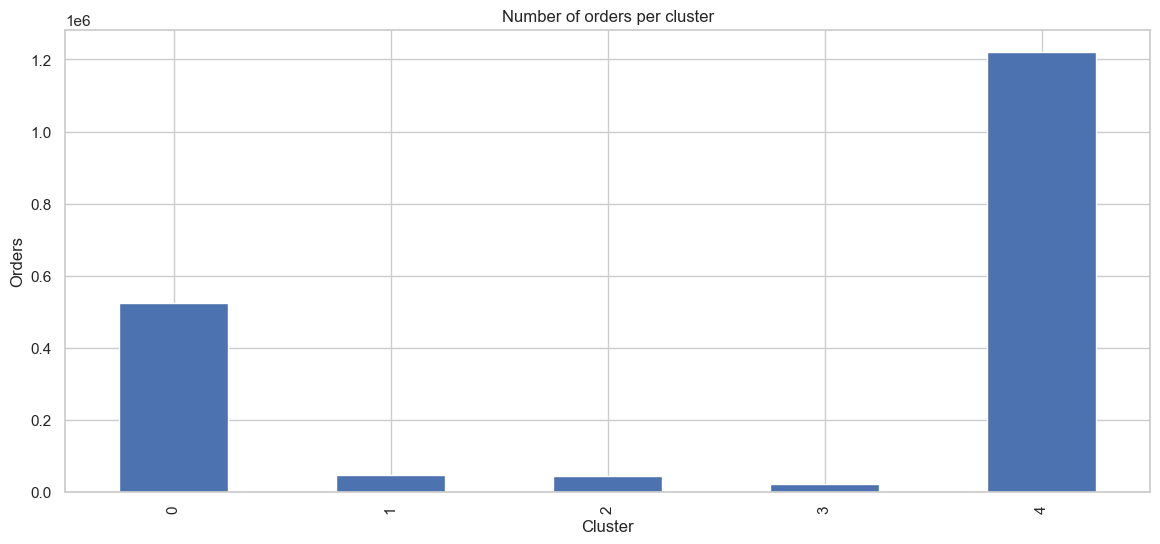

In [103]:
import matplotlib.pyplot as plt

order_segments["segment"].value_counts().sort_index().plot(
    kind="bar",
    title="Number of orders per cluster"
)
plt.xlabel("Cluster")
plt.ylabel("Orders")
plt.show()


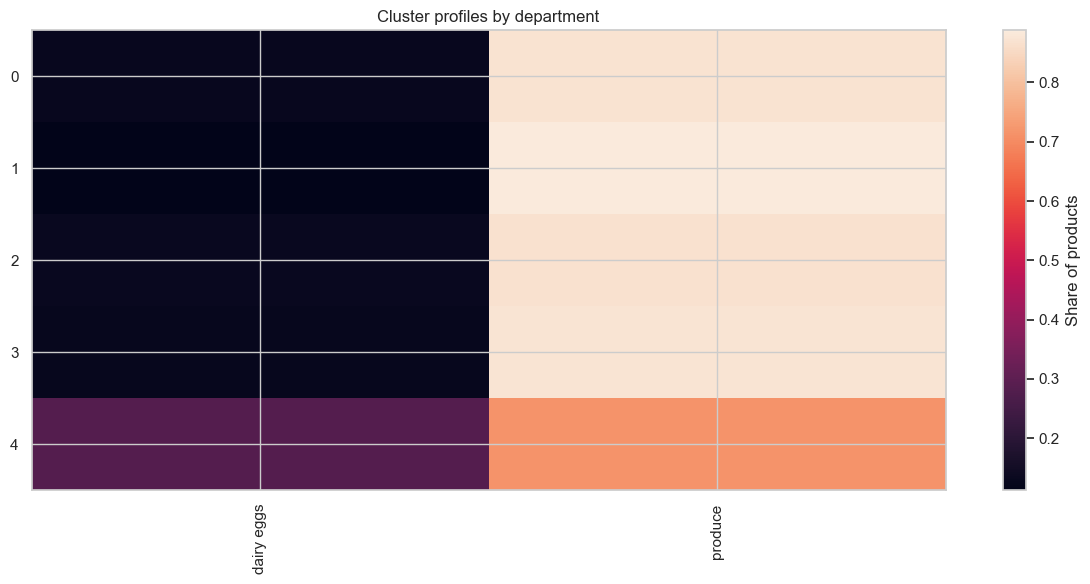

In [104]:
pivot = dept_profile.pivot(
    index="segment",
    columns="department",
    values="share"
).fillna(0)

plt.figure(figsize=(12, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Share of products")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Cluster profiles by department")
plt.tight_layout()
plt.show()


## Revenue simulation

In [105]:



# Order revenue
order_revenue = (
    order_products_prior
    .merge(products[["product_id", "synthetic_price"]], on="product_id", how="left")
    .groupby("order_id")["synthetic_price"]
    .sum()
    .reset_index(name="order_revenue")
)

# Add user_id + segment to each order
orders_with_seg = (
    orders[["order_id", "user_id"]]
    .merge(order_segments, on="order_id", how="inner")
    .merge(order_revenue, on="order_id", how="left")
)

# Total revenue per user
customer_revenue = (
    orders_with_seg
    .groupby("user_id")["order_revenue"]
    .sum()
    .reset_index(name="total_customer_revenue")
)

# Assign ONE segment per user (most frequent segment across their orders)
user_segment = (
    orders_with_seg
    .groupby(["user_id", "segment"])
    .size()
    .reset_index(name="n_orders")
    .sort_values(["user_id", "n_orders"], ascending=[True, False])
    .drop_duplicates("user_id")[["user_id", "segment"]]
)

financials = customer_revenue.merge(user_segment, on="user_id", how="left")

# User-level segment report
user_segment_report = (
    financials
    .groupby("segment")
    .agg(
        total_revenue=("total_customer_revenue", "sum"),
        avg_customer_value=("total_customer_revenue", "mean"),
        customers=("user_id", "count")
    )
    .reset_index()
)

user_segment_report["revenue_share"] = (
    user_segment_report["total_revenue"] / user_segment_report["total_revenue"].sum()
)

user_segment_report.sort_values("total_revenue", ascending=False)


,segment,total_revenue,avg_customer_value,customers,revenue_share
4,4,70570927.38,486.350574,145103,0.834567
0,0,13929054.26,246.566846,56492,0.164724
1,1,34247.82,84.562519,405,0.000405
2,2,21233.45,63.007270,337,0.000251
3,3,4484.73,49.282747,91,0.000053


In [106]:
## Build Core Financial KPIs

total_revenue = financials["total_customer_revenue"].sum()
total_customers = financials["user_id"].nunique()
avg_customer_value = financials["total_customer_revenue"].mean()

print("TOTAL SIMULATED REVENUE:", round(total_revenue, 2))
print("TOTAL CUSTOMERS:", total_customers)
print("AVG CUSTOMER VALUE:", round(avg_customer_value, 2))



TOTAL SIMULATED REVENUE: 84559947.64
TOTAL CUSTOMERS: 202428
AVG CUSTOMER VALUE: 417.73


In [107]:
##Identifying the best segment

In [108]:
top_seg = user_segment_report.sort_values("total_revenue", ascending=False).iloc[0]
print("TOP SEGMENT:", top_seg["segment"])
print("REVENUE SHARE:", round(top_seg["revenue_share"]*100, 2), "%")
print("AVG CUSTOMER VALUE:", round(top_seg["avg_customer_value"], 2))


TOP SEGMENT: 4.0
REVENUE SHARE: 83.46 %
AVG CUSTOMER VALUE: 486.35


In [109]:
##Add a department revenue table

In [110]:
dept_revenue = (
    order_products_prior
    .merge(products[["product_id", "department", "synthetic_price"]], on="product_id", how="left")
    .groupby("department")["synthetic_price"]
    .sum()
    .reset_index(name="department_revenue")
)

dept_revenue["revenue_share"] = dept_revenue["department_revenue"] / dept_revenue["department_revenue"].sum()
dept_revenue.sort_values("department_revenue", ascending=False).head(10)


,department,department_revenue,revenue_share
19,produce,25435417.26,0.197594
7,dairy eggs,20618147.73,0.160171
3,beverages,11417987.25,0.088700
10,frozen,10813680.67,0.084005
20,snacks,9796882.78,0.076107
8,deli,6570233.08,0.051040
16,pantry,6310727.25,0.049025
13,meat seafood,6144493.87,0.047733
11,household,5731224.40,0.044523
1,babies,4556795.77,0.035399


In [111]:
#Simulate profit

In [112]:
margin_map = {
    "produce": 0.22,
    "dairy eggs": 0.25,
    "beverages": 0.30,
    "snacks": 0.28,
    "meat seafood": 0.20,
    "household": 0.35,
    "personal care": 0.40,
    "babies": 0.30,
    "pets": 0.32,
    "alcohol": 0.38,
}

products["margin"] = products["department"].str.lower().map(margin_map).fillna(0.28)

profit_by_order = (
    order_products_prior
    .merge(products[["product_id", "synthetic_price", "margin"]], on="product_id", how="left")
)
profit_by_order["profit"] = profit_by_order["synthetic_price"] * profit_by_order["margin"]

profit_summary = profit_by_order["profit"].sum()
print("SIMULATED TOTAL PROFIT:", round(profit_summary, 2))


SIMULATED TOTAL PROFIT: 34824761.92


In [113]:
import os

os.makedirs("data", exist_ok=True)

# FP-Growth rules (this exists in your notebook)
rules.to_csv("data/fpg_rules.csv", index=False)

# Order-level segments
order_segments.to_csv("data/order_segments.csv", index=False)

# Segment financial summary (you compute user_segment_report)
user_segment_report.to_csv("data/user_segment_report.csv", index=False)

# Department revenue table
dept_revenue.to_csv("data/dept_revenue.csv", index=False)

In [ ]:
# OBJECTIVE: Identify and export the top 10 strongest product
# bundles (1-to-1 association rules) for each department.

# Filter for simple 1-to-1 association rules
rules_top = rules[
    (rules['antecedents'].apply(lambda x: len(x) == 1)) &
    (rules['consequents'].apply(lambda x: len(x) == 1))
].copy()

# Extract individual product IDs from frozensets
rules_top['product_id'] = rules_top['antecedents'].apply(lambda x: list(x)[0])
rules_top['recommended_product_id'] = rules_top['consequents'].apply(lambda x: list(x)[0])

rules_top[['product_id','recommended_product_id']] = \
    rules_top[['product_id','recommended_product_id']].astype(int)

# Merge with base product info and department IDs
rules_top = rules_top.merge(
    products[['product_id','product_name','department_id']],
    on='product_id',
    how='left'
)

# Merge with recommended product names
rules_top = rules_top.merge(
    products[['product_id','product_name']],
    left_on='recommended_product_id',
    right_on='product_id',
    how='left',
    suffixes=('_base','_recommended')
)

# Merge with department names
rules_top = rules_top.merge(
    departments[['department_id','department']],
    on='department_id',
    how='left'
)

# Sort by department then by strongest association (Lift and Confidence)
rules_top = rules_top.sort_values(
    by=['department','lift','confidence'],
    ascending=[True, False, False]
)

# Extract top 10 bundles per department group
top10_per_department = (
    rules_top
    .groupby('department')
    .head(10)
)

# Select and organize relevant metrics for the report
top10_per_department = top10_per_department[
    ['department', 'product_name_base', 'product_name_recommended', 'lift', 'confidence', 'support']
]

# Uncomment the line below to export the results to CSV
# top10_per_department.to_csv("bundle_top10_by_department.csv", index=False)

print("Exported bundle_top10_by_department.csv")

In [ ]:
# OBJECTIVE: Identify and export the top 10 strongest product
# bundles (1-to-1 association rules) for each aisle.

# Filter for simple 1-to-1 association rules
rules_top = rules[
    (rules['antecedents'].apply(lambda x: len(x) == 1)) &
    (rules['consequents'].apply(lambda x: len(x) == 1))
].copy()

# Extract individual product IDs from frozensets
rules_top['product_id'] = rules_top['antecedents'].apply(lambda x: list(x)[0])
rules_top['recommended_product_id'] = rules_top['consequents'].apply(lambda x: list(x)[0])

rules_top[['product_id','recommended_product_id']] = \
    rules_top[['product_id','recommended_product_id']].astype(int)

# Merge with base product info and aisle IDs
rules_top = rules_top.merge(
    products[['product_id','product_name','aisle_id']],
    on='product_id',
    how='left'
)

# Merge with recommended product names
rules_top = rules_top.merge(
    products[['product_id','product_name']],
    left_on='recommended_product_id',
    right_on='product_id',
    how='left',
    suffixes=('_base','_recommended')
)

# Merge with aisle names
rules_top = rules_top.merge(
    aisles[['aisle_id','aisle']],
    on='aisle_id',
    how='left'
)

# Sort by aisle then by strongest association (Lift and Confidence)
rules_top = rules_top.sort_values(
    by=['aisle','lift','confidence'],
    ascending=[True, False, False]
)

# Extract top 10 bundles per aisle group
top10_per_aisle = (
    rules_top
    .groupby('aisle')
    .head(10)
)

# Select and organize relevant metrics for the report
top10_per_aisle = top10_per_aisle[
    ['aisle', 'product_name_base', 'product_name_recommended', 'lift', 'confidence', 'support']
]

# Uncomment the line below to export the results to CSV
# top10_per_aisle.to_csv("bundle_top10_by_aisle.csv", index=False)

print("Exported bundle_top10_by_aisle.csv")

In [ ]:
# OBJECTIVE: Identify and export the top 5 most frequently
# ordered products for each department.

# Calculate total order frequency for each product
product_sales = (
    order_products
    .groupby('product_id')
    .size()
    .reset_index(name='total_orders')
)

# Merge with product details (name and department ID)
product_sales = product_sales.merge(
    products[['product_id', 'product_name', 'department_id']],
    on='product_id',
    how='left'
)

# Merge with department names
product_sales = product_sales.merge(
    departments[['department_id', 'department']],
    on='department_id',
    how='left'
)

# Sort by department name (A-Z) and sales volume (Descending)
product_sales = product_sales.sort_values(
    by=['department', 'total_orders'],
    ascending=[True, False]
)

# Extract the top 5 selling products per department group
top5_per_department = (
    product_sales
    .groupby('department')
    .head(5)
)

# # Uncomment the line below to export the final result to CSV
#top5_per_department.to_csv("top5_selling_by_department.csv", index=False)

print("Successfully exported: top5_selling_by_department.csv")

In [ ]:
# OBJECTIVE: Identify and export the top 5 most frequently
# ordered products for each aisle.

# Count total sales per product
product_sales = (
    order_products
    .groupby('product_id')
    .size()
    .reset_index(name='total_orders')
)

# Merge product details including aisle IDs
product_sales = product_sales.merge(
    products[['product_id', 'product_name', 'aisle_id']],
    on='product_id',
    how='left'
)

# Merge with aisle names
product_sales = product_sales.merge(
    aisles[['aisle_id', 'aisle']],
    on='aisle_id',
    how='left'
)

# Sort by aisle name (A-Z) and sales volume (Descending)
product_sales = product_sales.sort_values(
    by=['aisle', 'total_orders'],
    ascending=[True, False]
)

# Extract the top 5 selling products per aisle
top5_per_aisle = (
    product_sales
    .groupby('aisle')
    .head(5)
)

# Select and organize final columns
top5_per_aisle = top5_per_aisle[
    ['product_id', 'total_orders', 'product_name', 'aisle_id', 'aisle']
]

# Uncomment the line below to export the final result to CSV
# top5_per_aisle.to_csv("top5_selling_by_aisle.csv", index=False)

print("Successfully exported: top5_selling_by_aisle.csv")

In [ ]:
import plotly.express as px
# OBJECTIVE: Visualize and export the volume of orders across
# different days of the week to identify peak shopping periods.

# Define the custom sort order starting from Monday to Sunday
order = [1, 2, 3, 4, 5, 6, 0]

# Calculate and reindex order frequency by day of week
count_data = data['order_dow'].value_counts().reindex(order)

# Prepare the data for visualization
df_plot = pd.DataFrame({
    'Day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    'Total Orders': count_data.values
})

# Create a bar chart showing the busiest days
fig = px.bar(
    df_plot,
    x='Day',
    y='Total Orders',
    title='Busiest Days of the Week'
)

# Uncomment the line below to export the chart to an interactive HTML file
# fig.write_html("busiest_days.html")

print("Successfully exported: busiest_days.html")

In [ ]:
# OBJECTIVE: Analyze and visualize order distribution by hour
# to identify peak shopping times throughout the day.

# Count occurrences and sort by chronological hour (0-23)
hour_counts = data['order_hour_of_day'].value_counts().sort_index()

# Prepare data for plotting
df_hour = pd.DataFrame({
    'Hour': hour_counts.index,
    'Total Orders': hour_counts.values
})

# Create an interactive bar chart using Plotly
fig = px.bar(
    df_hour,
    x='Hour',
    y='Total Orders',
    title='Busiest Hours of the Day',
    labels={
        'Hour': 'Hour (24h format)',
        'Total Orders': 'Total Orders'
    }
)

# Customize visual appearance with a specific color theme
fig.update_traces(marker_color='gold')

# Uncomment the line below to export the chart to an HTML file
# fig.write_html("busiest_hours.html")

print("Successfully exported: busiest_hours.html")

In [ ]:
# OBJECTIVE: Visualize the distribution of orders across customer
# segments to understand the scale and impact of each group.

# Compute total number of orders and relative share per cluster
cluster_counts = (
    order_segments["segment"]
    .value_counts()
    .sort_index()
    .reset_index()
)
cluster_counts.columns = ["Cluster_ID", "Total_Orders"]

# Calculate percentage contribution for each segment
cluster_counts["Percentage"] = (
    cluster_counts["Total_Orders"] /
    cluster_counts["Total_Orders"].sum() * 100
).round(1)

# Map numeric cluster IDs to descriptive business labels
cluster_names = {
    0: "Segment A - Fresh Focus",
    1: "Segment B - Low Activity",
    2: "Segment C - Balanced Buyers",
    3: "Segment D - Household Focus",
    4: "Segment E - High Value"
}
cluster_counts["Customer_Segment"] = cluster_counts["Cluster_ID"].map(cluster_names)

# Create an interactive bar chart with segment colors
fig = px.bar(
    cluster_counts,
    x="Customer_Segment",
    y="Total_Orders",
    text="Percentage",
    color="Customer_Segment",
    title="Order Distribution by Customer Segment"
)

# Enhance labels and hover information for better readability
fig.update_traces(
    texttemplate="%{text}%",
    textposition="outside",
    hovertemplate=(
        "<b>%{x}</b><br>"
        "Total Orders: %{y}<br>"
        "Share of Orders: %{text}%"
        "<extra></extra>"
    )
)

# Refine layout aesthetics and axis titles
fig.update_layout(
    xaxis_title="Customer Segment",
    yaxis_title="Number of Orders",
    showlegend=False,
    height=600
)

# Uncomment the line below to export the chart to an HTML file
# fig.write_html("orders_per_cluster.html")

print("Successfully exported: orders_per_cluster.html")

In [ ]:
# OBJECTIVE: Create a heat-map profile to visualize the purchase
# behavior and department preferences across different customer segments.

# Transform data into a pivot table for segment-department analysis
pivot = (
    dept_profile
    .pivot(index="segment", columns="department", values="share")
    .fillna(0)
)

# Scale values to percentage format
pivot_percent = pivot * 100

# Map numeric segment IDs to descriptive business labels
cluster_names = {
    0: "Segment A - Fresh Focus",
    1: "Segment B - Low Activity",
    2: "Segment C - Balanced Buyers",
    3: "Segment D - Household Focus",
    4: "Segment E - High Value"
}
pivot_percent.index = pivot_percent.index.map(cluster_names)

# Generate an interactive heatmap using the Yellow-Orange-Red scale
fig = px.imshow(
    pivot_percent,
    aspect="auto",
    color_continuous_scale="YlOrRd",
    labels=dict(
        x="Department",
        y="Customer Segment",
        color="Purchase Share (%)"
    ),
    title="Customer Segment Profiles by Department"
)

# Refine axis labels and chart dimensions for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    height=600
)

# Uncomment the line below to export the visualization to an HTML file
# fig.write_html("cluster_department_profiles.html")

print("Successfully exported: cluster_department_profiles.html")